In [6]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline
import re
import plotly.express as px
import plotly.graph_objects as go

In [7]:
df = pd.read_csv('./output_scrapy.csv')

In [8]:
df.head()

,PrimaryCategory,Description,AuthenticationModel,APIForumMessageBoards,SupportedResponseFormats,DocsHomePageUR,DeviceSpecific,ArchitecturalStyle,RestrictedAccess,SupportEmailAddress,Scope,IsThisanUnofficialAPI,SupportedRequestFormats,APIProvider,APIPortalHomePage,APIEndpoint,SSLSupport,Title,IstheAPIDesign,SecondaryCategories
0,Mapping,Google Maps' services have been split into mul...,API Key,http://groups-beta.google.com/group/Google-Map...,"JSON, KML, XML",https://developers.google.com/maps/,No,REST,No,NaN,Single purpose API,No,"KML, URI Query String/CRUD, XML, VML, JavaScript",Google,https://developers.google.com/maps/,https://www.google.com/maps/embed/v1/,No,Google Maps API,No,Viewer
1,Social,"It has been split into multiple APIs, includin...",OAuth 2,http://groups.google.com/group/twitter-develop...,"Atom, JSON, RSS, XML",https://dev.twitter.com/rest/public,No,REST,No,api@twitter.com,Single purpose API,No,URI Query String/CRUD,Twitter,https://dev.twitter.com/rest/public,http://twitter.com/statuses/,No,Twitter API,Yes,Blogging
2,Video,The Data API allows users to integrate their p...,API Key,http://groups.google.com/group/youtube-api/,"XML, JSON, GData, Atom, RSS",https://developers.google.com/youtube/,No,REST,No,NaN,Single purpose API,No,"Atom, GData, RSS, URI Query String/CRUD, Atom ...",Google,https://developers.google.com/youtube/,https://www.youtube.com/iframe_api,No,YouTube API,No,Media
3,Photos,The Flickr API can be used to retrieve photos ...,OAuth 1,http://www.flickr.com/groups/api,"JSON, XML, PHP, XML-RPC",http://www.flickr.com/services/api/,No,REST,No,NaN,Single purpose API,No,"URI Query String/CRUD, XML, PHP, XML-RPC",Flickr,http://www.flickr.com/services/api/,http://api.flickr.com/services/,Yes,Flickr API,No,Video
4,Social,Its functions have been split among the follow...,"API Key, OAuth 2",http://forum.developers.facebook.com/,JSON,https://developers.facebook.com/,No,REST,No,NaN,Single purpose API,No,URI Query String/CRUD,Facebook,https://developers.facebook.com/,http://api.facebook.com/restserver.php,Yes,Facebook API,No,Webhooks


In [9]:
INPUT_CSV = './output_scrapy.csv'
OUTPUT_CSV = './output_scrapy_cleaned.csv'

COLUMNS_TO_KEEP = [
    'PrimaryCategory', 'Title', 'Description', 'APIProvider', 'APIEndpoint',
    'SupportedResponseFormats', 'SupportedRequestFormats', 'AuthenticationModel',
    'ArchitecturalStyle', 'RestrictedAccess', 'SSLSupport', 'IsThisanUnofficialAPI',
    'SecondaryCategories'
]

In [10]:
def normalize_bool(val):
    if pd.isna(val):
        return 'false'
    val = str(val).strip().lower()
    if val in ['yes', 'y', 'true', '1']:
        return 'true'
    return 'false'

def normalize_list(val):
    if pd.isna(val):
        return ''
    # Replace commas inside brackets/parentheses with semicolons, then split on commas
    val = re.sub(r'\(([^)]*)\)', lambda m: m.group(0).replace(',', ';'), str(val))
    items = [x.strip() for x in re.split(r',|;', val) if x.strip()]
    return '|'.join(sorted(set(items)))

def clean_text(val):
    if pd.isna(val):
        return ''
    val = str(val)
    val = re.sub(r'\s+', ' ', val) 
    val = val.replace('"', "'")
    return val.strip()

In [11]:
def merge_duplicates(df):
    key_cols = ['APIProvider', 'APIEndpoint']
    df['merge_key'] = df['APIProvider'].fillna('') + '|' + df['APIEndpoint'].fillna('')
    grouped = df.groupby('merge_key', as_index=False)
    def merge_group(g):
        merged = {}
        for col in df.columns:
            if col == 'merge_key':
                continue
            vals = g[col].dropna().unique()
            if col in ['PrimaryCategory', 'SecondaryCategories']:
                merged[col] = '|'.join(sorted(set(normalize_list(';'.join(vals)).split('|'))))
            elif col in ['SupportedResponseFormats', 'SupportedRequestFormats']:
                merged[col] = '|'.join(sorted(set(normalize_list(';'.join(vals)).split('|'))))
            elif col in ['Description']:
                merged[col] = ' '.join([clean_text(v) for v in vals])
            elif col in ['RestrictedAccess', 'SSLSupport', 'IsThisanUnofficialAPI']:
                merged[col] = normalize_bool(';'.join(vals))
            else:
                merged[col] = vals[0] if len(vals) > 0 else ''
        return pd.Series(merged)
    merged_df = grouped.apply(merge_group).reset_index(drop=True)
    return merged_df

In [12]:
print('Reading CSV...')
df = pd.read_csv(INPUT_CSV, low_memory=False)

df.columns = [c.strip() for c in df.columns]

for col in COLUMNS_TO_KEEP:
    if col not in df.columns:
        df[col] = ''

df = df[COLUMNS_TO_KEEP]

for col in ['PrimaryCategory', 'Title', 'APIProvider', 'APIEndpoint']:
    df[col] = df[col].apply(clean_text)
for col in ['SupportedResponseFormats', 'SupportedRequestFormats', 'SecondaryCategories']:
    df[col] = df[col].apply(normalize_list)
for col in ['RestrictedAccess', 'SSLSupport', 'IsThisanUnofficialAPI']:
    df[col] = df[col].apply(normalize_bool)
df['Description'] = df['Description'].apply(clean_text)
df['AuthenticationModel'] = df['AuthenticationModel'].apply(clean_text)
df['ArchitecturalStyle'] = df['ArchitecturalStyle'].apply(clean_text)

before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f'Removed {before - after} exact duplicate rows.')

# Merge overlapping/near-duplicate APIs
before = len(df)
df = merge_duplicates(df)
after = len(df)
print(f'Merged to {after} unique APIs.')

df = df.fillna('N/A')

df.to_csv(OUTPUT_CSV, index=False)
print(f'Cleaned CSV saved to {OUTPUT_CSV}')
print(f'Columns: {list(df.columns)}')
print(f'Total rows: {len(df)}')

Reading CSV...
Removed 109 exact duplicate rows.


C:\Users\SyedHabib14\AppData\Local\Temp\ipykernel_17024\670287114.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = grouped.apply(merge_group).reset_index(drop=True)


Merged to 11200 unique APIs.
Cleaned CSV saved to ./output_scrapy_cleaned.csv
Columns: ['merge_key', 'PrimaryCategory', 'Title', 'Description', 'APIProvider', 'APIEndpoint', 'SupportedResponseFormats', 'SupportedRequestFormats', 'AuthenticationModel', 'ArchitecturalStyle', 'RestrictedAccess', 'SSLSupport', 'IsThisanUnofficialAPI', 'SecondaryCategories']
Total rows: 11200


In [13]:
new_df = pd.read_csv('./output_scrapy_cleaned.csv')

In [14]:
new_df.shape

(11200, 14)

In [15]:
new_df.head(200)

,merge_key,PrimaryCategory,Title,Description,APIProvider,APIEndpoint,SupportedResponseFormats,SupportedRequestFormats,AuthenticationModel,ArchitecturalStyle,RestrictedAccess,SSLSupport,IsThisanUnofficialAPI,SecondaryCategories
0,1&1|http://demo.qooxdoo.org/5.0.1/apiviewer/#q...,Mobile,qx.Mobile API,qx.Mobile API provides developers a way to bui...,1&1,http://demo.qooxdoo.org/5.0.1/apiviewer/#qx.ui...,None Specified,URI Query String/CRUD,Other/Custom,REST,False,True,False,Application Development|Framework
1,1&1|http://demo.qooxdoo.org/5.0.1/apiviewer/#q...,Application Development,qx.Desktop API,qx.Desktop API provides developers a way to bu...,1&1,http://demo.qooxdoo.org/5.0.1/apiviewer/#qx.ui...,None Specified,URI Query String/CRUD,Other/Custom,REST,False,True,False,Framework
2,1&1|http://demo.qooxdoo.org/5.0.1/website-api/,Web Site Management,qx. Website API,qx. Website API provides developers a way to b...,1&1,http://demo.qooxdoo.org/5.0.1/website-api/,None Specified,URI Query String/CRUD,Other/Custom,REST,False,True,False,Framework|Modules
3,1&1|https://www.onehourtranslation.com/api/2,Tools,OneHourTranslation API,The human translation API provides direct inte...,1&1,https://www.onehourtranslation.com/api/2,JSON,URI Query String/CRUD,API Key,REST,False,True,False,Language|Translation
4,"100TB, DIY|https://api.diy.org",Education,DIY API,DIY is a social network for DIY projects aimed...,"100TB, DIY",https://api.diy.org,JSON,URI Query String/CRUD,Unspecified,REST,False,False,False,Project Management|Social
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,AddressFinder|https://api.addressfinder.io/api...,Addresses,AddressFinder Reverse Geocode API,The AddressFinder Reverse Geocode API returns ...,AddressFinder,https://api.addressfinder.io/api/nz/address/,JSON,JSON|URI Query String/CRUD,API Key,REST,False,False,False,Search
196,AddressOCR|,Addresses,AddressOCR API,The AddressOCR API allows developers to get re...,AddressOCR,NaN,JSON,None Specified,API Key,REST,False,True,False,Data|OCR|Postal|Postcards
197,Addrexx|https://www.addrexx.com/api,eCommerce,Addrexx API,The Addrexx API allows developers to integrate...,Addrexx,https://www.addrexx.com/api,JSON|JSONP,JSONP|URI Query String/CRUD,API Key,REST,False,True,False,Addresses|Validation
198,Adform|api.adform.com,Advertising,Adform Campaigns API,The Adform Campaigns API integrates campaigns ...,Adform,api.adform.com,HTML|JSON|XML,JSON|URI Query String/CRUD,HTTP Basic Auth,REST,False,True,False,Campaigns|Inventory|Marketing|Ordering|Reporting


In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11200 entries, 0 to 11199
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   merge_key                 11200 non-null  object
 1   PrimaryCategory           11182 non-null  object
 2   Title                     11200 non-null  object
 3   Description               11199 non-null  object
 4   APIProvider               6996 non-null   object
 5   APIEndpoint               10776 non-null  object
 6   SupportedResponseFormats  11200 non-null  object
 7   SupportedRequestFormats   11199 non-null  object
 8   AuthenticationModel       6850 non-null   object
 9   ArchitecturalStyle        11068 non-null  object
 10  RestrictedAccess          11200 non-null  bool  
 11  SSLSupport                11200 non-null  bool  
 12  IsThisanUnofficialAPI     11200 non-null  bool  
 13  SecondaryCategories       10175 non-null  object
dtypes: bool(3), object(11)

In [17]:
new_df.describe()

,merge_key,PrimaryCategory,Title,Description,APIProvider,APIEndpoint,SupportedResponseFormats,SupportedRequestFormats,AuthenticationModel,ArchitecturalStyle,RestrictedAccess,SSLSupport,IsThisanUnofficialAPI,SecondaryCategories
count,11200,11182,11200,11199,6996,10776,11200,11199,6850,11068,11200,11200,11200,10175
unique,11200,508,11197,11193,4102,10681,294,612,121,7,2,2,2,6554
top,1&1|http://demo.qooxdoo.org/5.0.1/apiviewer/#q...,Tools,HPE Haven OnDemand Speech Recognition API,The Betfair Exchange API is the platform on wh...,Independent Developer,Unspecified,JSON,URI Query String/CRUD,API Key,REST,False,True,False,Financial
freq,1,485,2,2,238,60,4756,5666,2689,10238,10283,6206,11133,121


In [18]:
new_df.isnull().sum()

merge_key                      0
PrimaryCategory               18
Title                          0
Description                    1
APIProvider                 4204
APIEndpoint                  424
SupportedResponseFormats       0
SupportedRequestFormats        1
AuthenticationModel         4350
ArchitecturalStyle           132
RestrictedAccess               0
SSLSupport                     0
IsThisanUnofficialAPI          0
SecondaryCategories         1025
dtype: int64

In [19]:
assert pd.notnull(df).all().all()

In [20]:
check1 = new_df['SSLSupport']
check1.head()

0     True
1     True
2     True
3     True
4    False
Name: SSLSupport, dtype: bool

In [21]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)

In [22]:
dupes = new_df.duplicated().sum()
print(f"Duplicate rows: {dupes}")

Duplicate rows: 0


C:\Users\SyedHabib14\AppData\Local\Temp\ipykernel_17024\2147654031.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index[:14], palette='viridis')


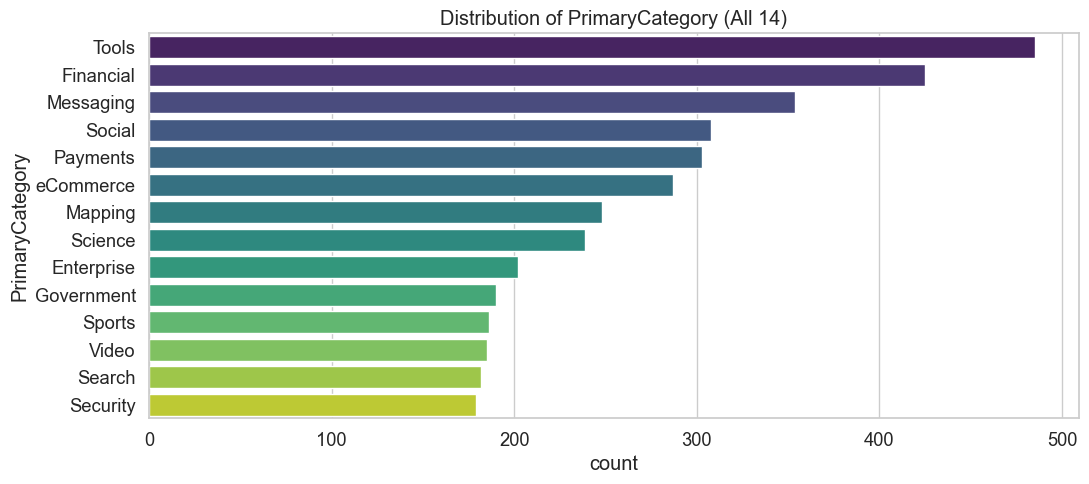

C:\Users\SyedHabib14\AppData\Local\Temp\ipykernel_17024\2147654031.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index[:14], palette='viridis')


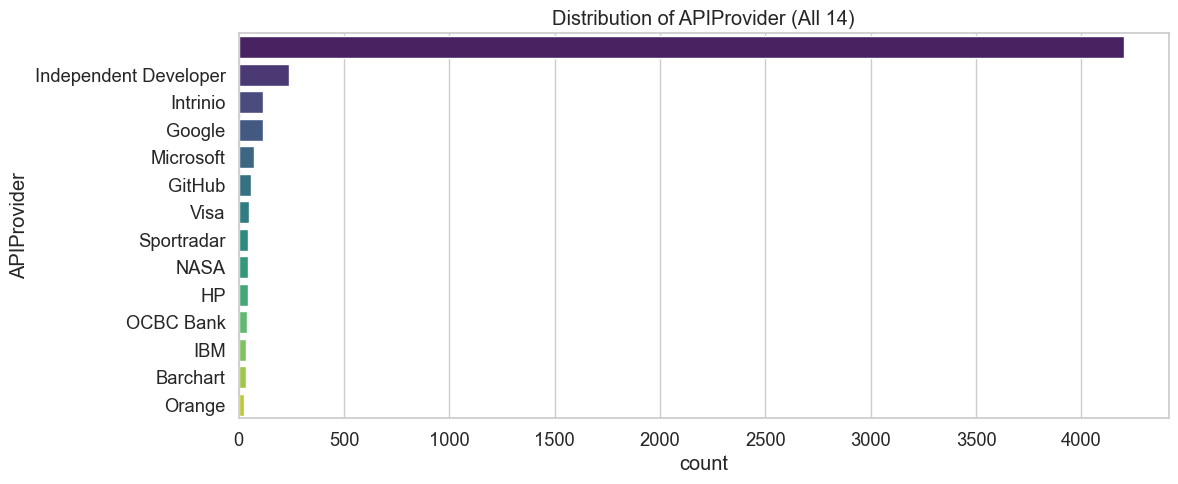

C:\Users\SyedHabib14\AppData\Local\Temp\ipykernel_17024\2147654031.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index[:14], palette='viridis')


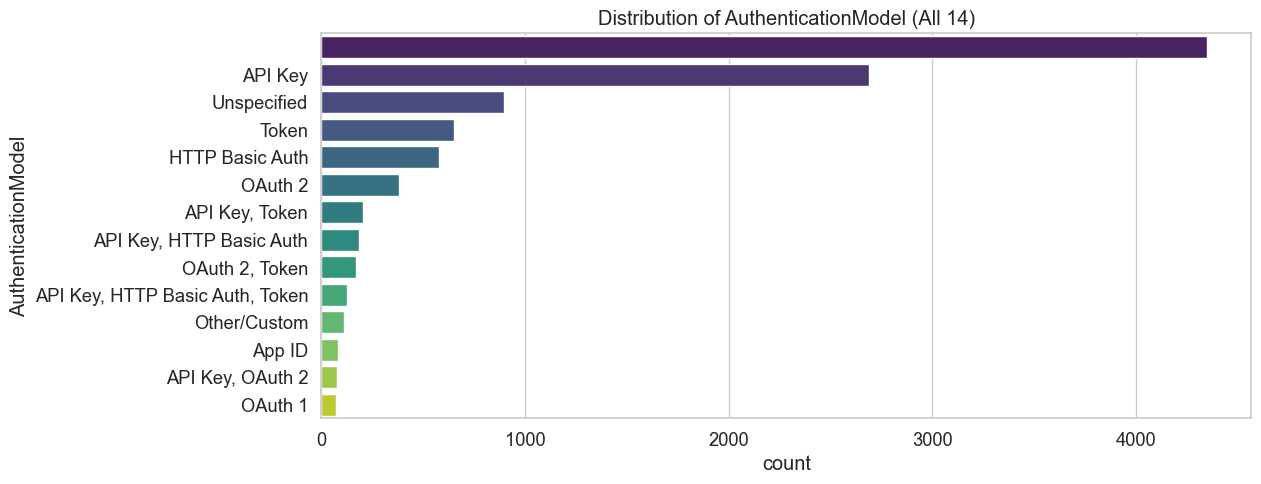

C:\Users\SyedHabib14\AppData\Local\Temp\ipykernel_17024\2147654031.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index[:14], palette='viridis')


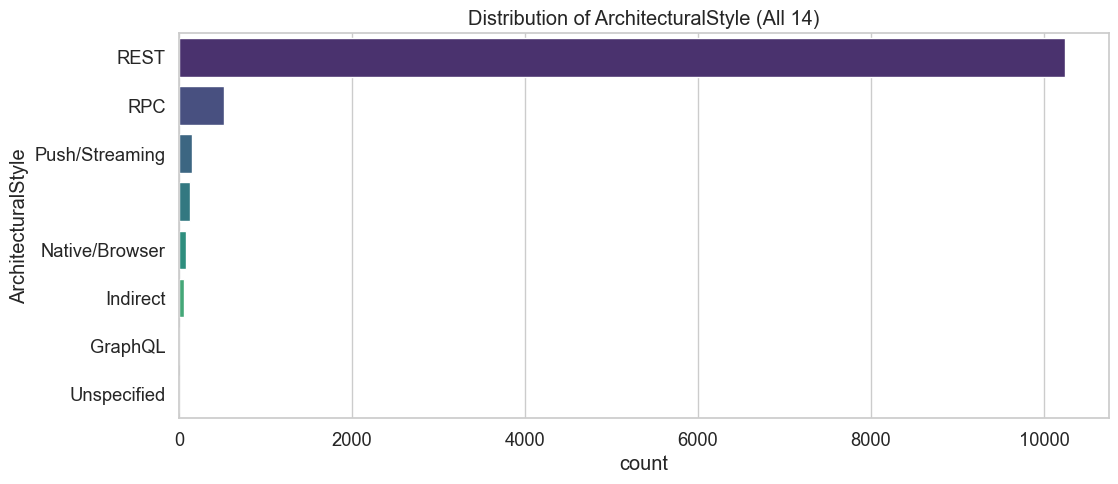

In [23]:
categorical_cols = ['PrimaryCategory', 'APIProvider', 'AuthenticationModel', 'ArchitecturalStyle']
for col in categorical_cols:
    plt.figure(figsize=(12, 5))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index[:14], palette='viridis')
    plt.title(f'Distribution of {col} (All 14)')
    plt.show()

In [39]:
top_cats = new_df['PrimaryCategory'].value_counts().nlargest(30)
fig = px.pie(values=top_cats.values, names=top_cats.index, title='Top 10 Primary Categories')
fig.show()

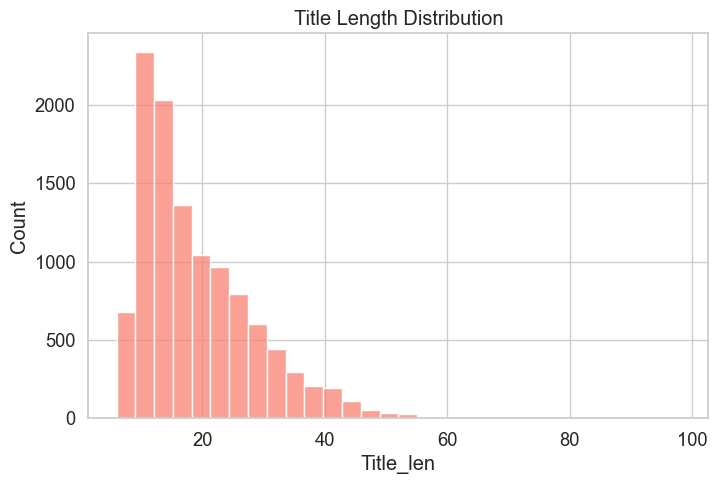

In [50]:
df['Title_len'] = new_df['Title'].astype(str).apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(df['Title_len'], bins=30, color='salmon')
plt.title('Title Length Distribution')
plt.show()


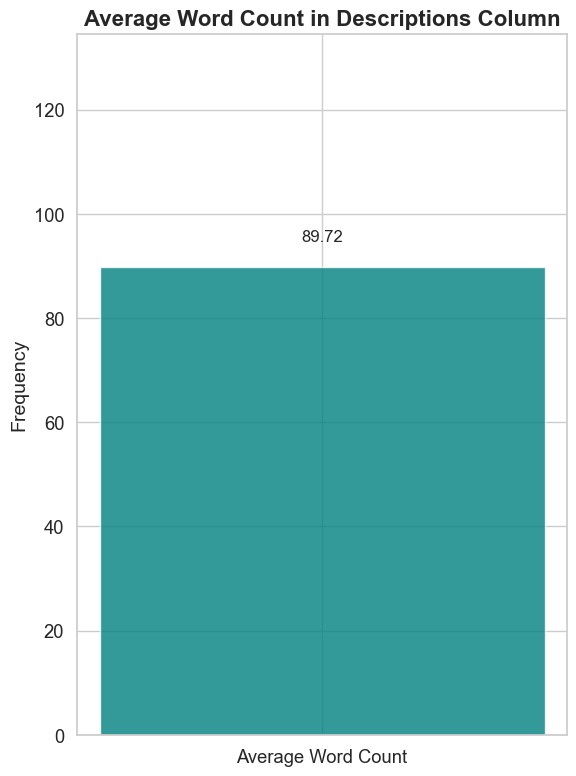

In [54]:
word_counts = new_df['Description'].dropna().apply(lambda x: len(str(x).split()))
average_word_count = word_counts.mean()

plt.figure(figsize=(6, 8))
plt.bar('Average Word Count', average_word_count, color='teal', alpha=0.8)

plt.title('Average Word Count in Descriptions Column', fontsize=16, fontweight='bold')
plt.ylabel('Frequency', fontsize=14)
plt.ylim(0, max(average_word_count*1.5, 10))

plt.text(0, average_word_count + max(average_word_count*0.05, 0.5),
         f'{average_word_count:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

C:\Users\SyedHabib14\AppData\Local\Temp\ipykernel_17024\1896683360.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




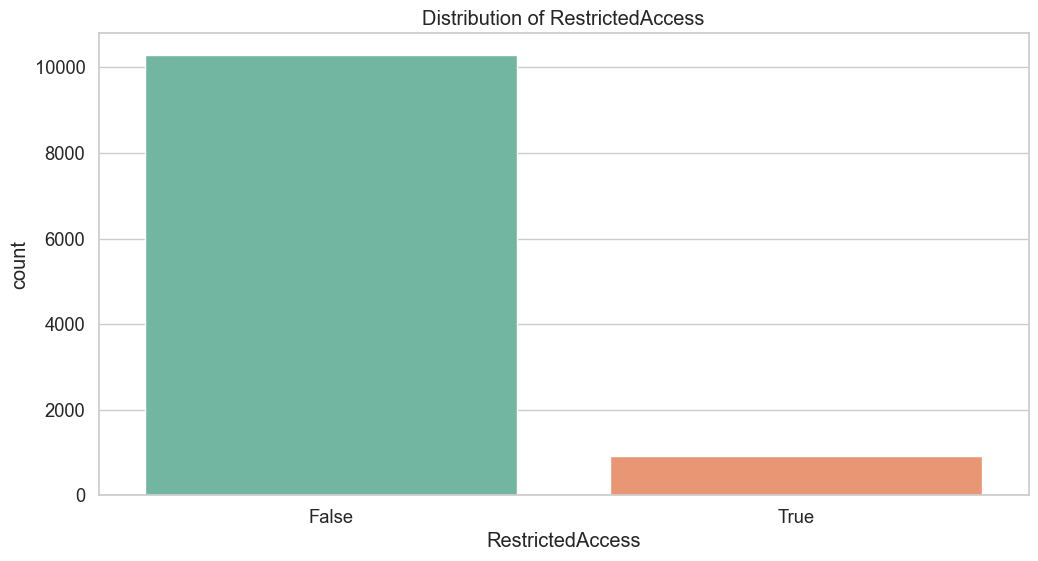

C:\Users\SyedHabib14\AppData\Local\Temp\ipykernel_17024\1896683360.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




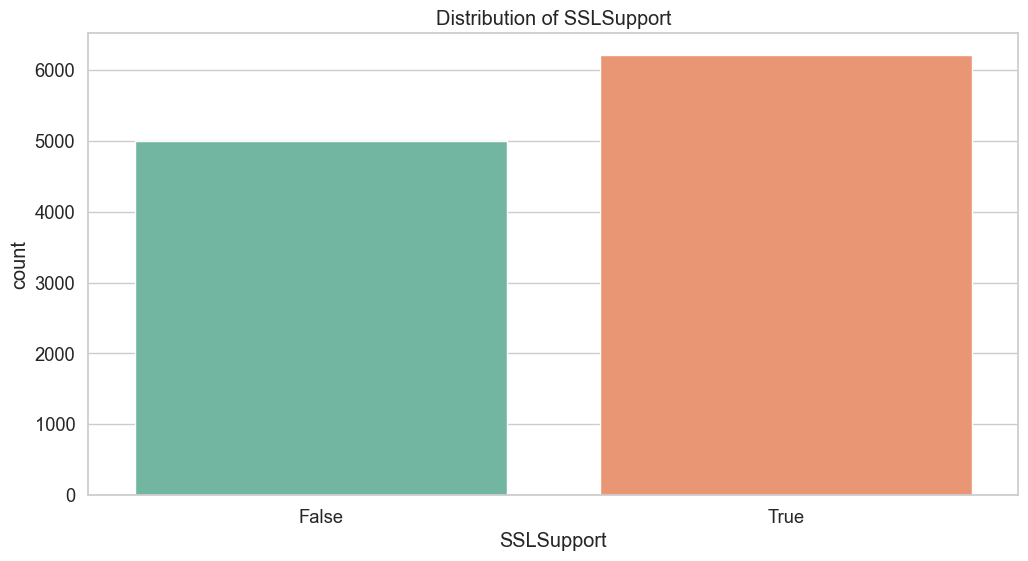

C:\Users\SyedHabib14\AppData\Local\Temp\ipykernel_17024\1896683360.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




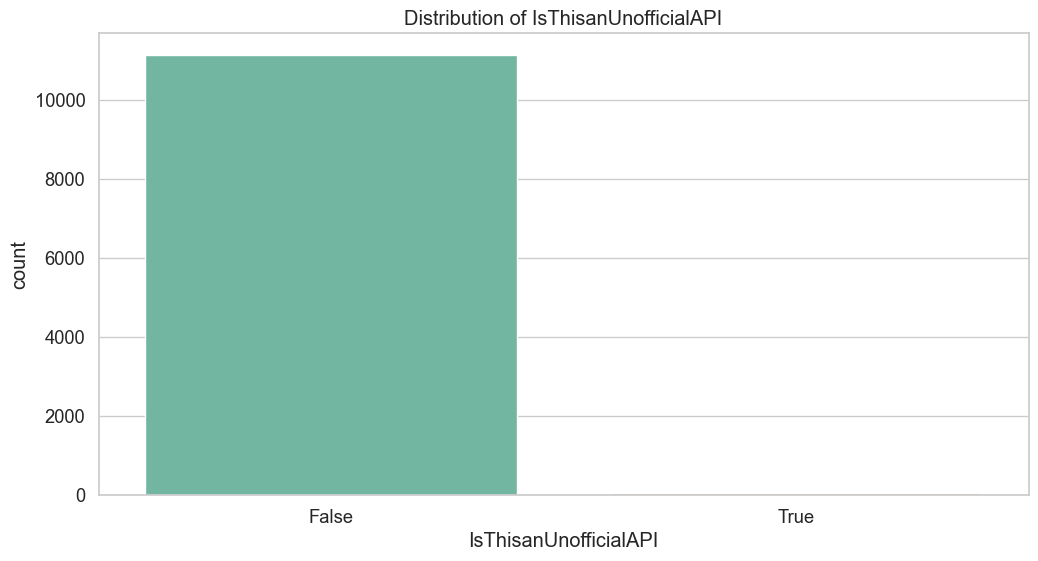

In [26]:
bool_cols = ['RestrictedAccess', 'SSLSupport', 'IsThisanUnofficialAPI']
for col in bool_cols:
    sns.countplot(data=new_df, x=col, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.show()

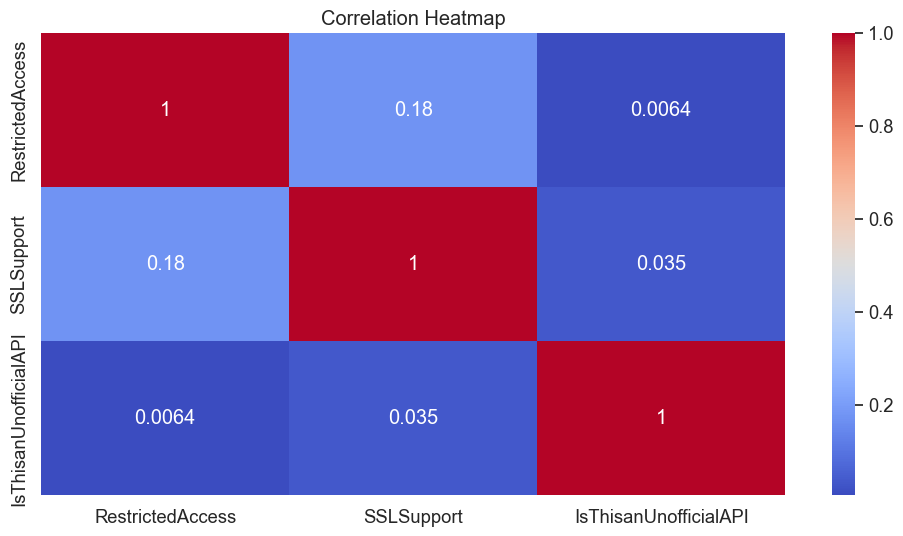

In [27]:
corr = new_df.select_dtypes(include=[np.number, 'bool']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [28]:
check2 = new_df['PrimaryCategory'].unique()
print(check2)

['Mobile' 'Application Development' 'Web Site Management' 'Tools'
 'Education' 'Monitoring' 'Security' 'Payments' 'Authorization' 'Identity'
 'Booking' 'Crime' 'Semantic Web' 'Financial' 'Healthcare' 'Products'
 'Customer Service' 'Mapping' 'Messaging' 'WebRTC' 'Email' 'Captcha'
 'eCommerce' 'Sports' 'Bitcoin' 'Machine Learning' '3D' 'Printing' 'Video'
 'Compliance' 'News Services|Social' 'Project Management' 'Real Estate'
 'Search' 'Entertainment' 'Enterprise' 'Telephony' 'File Sharing'
 'Weather' 'Photos' 'Infrastructure-as-a-Service' 'Scheduling' 'Games'
 'Music' 'Design' 'Customer Relationship Management' 'Content Management'
 'Banking' 'Recognition' 'Community' 'Business|Enterprise' 'Marine'
 'Travel' 'Advertising' 'Mapping|Music' 'Reference' 'Social' 'Data'
 'API Management' 'Voice' 'Images' 'Screenshots' 'Addresses|Financial'
 'Electronic Signature'
 'Currency|Language|Software-as-a-Service|Validation' 'Documents' 'API'
 'Art' 'Analytics' 'Invoicing' 'Transcription' 'Verificatio

In [29]:
check3 = new_df['PrimaryCategory'].nunique()
print('Total Number of Unique Values: ', check3)

Total Number of Unique Values:  508


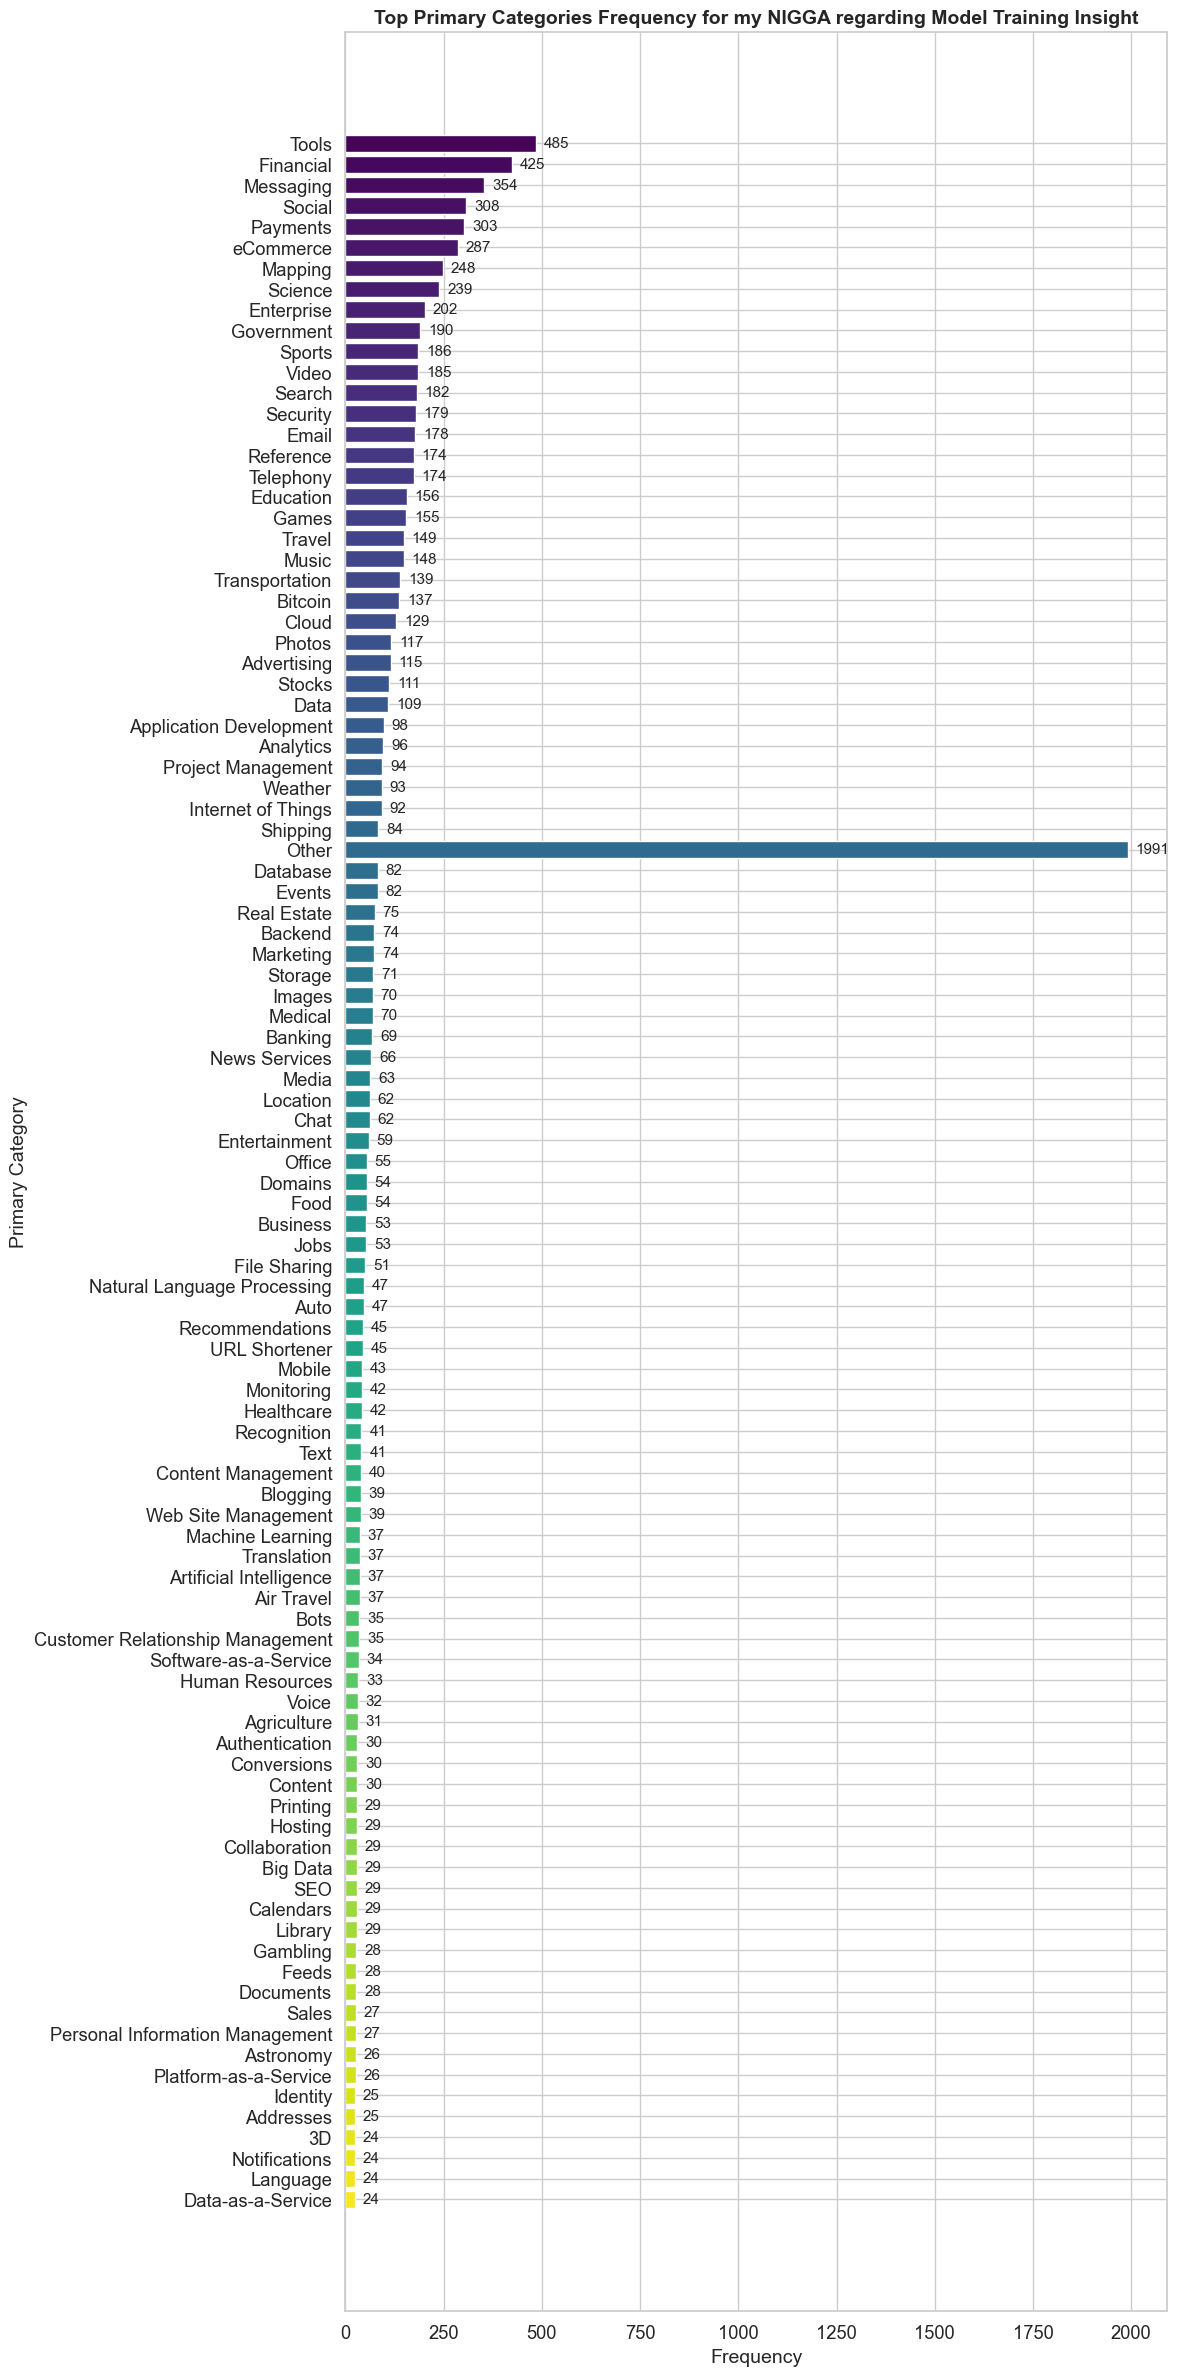

In [30]:
top_n = 100
category_counts = new_df['PrimaryCategory'].value_counts()
top_categories = category_counts.head(top_n)
other_count = category_counts.iloc[top_n:].sum()

# Append 'Other' category if needed
if other_count > 0:
    top_categories['Other'] = other_count

plt.figure(figsize=(12, 24))
sns.set_style('whitegrid')
colors = sns.color_palette("viridis", len(top_categories))

# Horizontal bar plot
bars = plt.barh(top_categories.index[::-1], top_categories.values[::-1], color=colors[::-1])

plt.title('Top Primary Categories Frequency for my NIGGA regarding Model Training Insight', fontsize=14, fontweight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Primary Category', fontsize=14)

# Annotate bar values on the right of bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(top_categories.values) * 0.01, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=11)

plt.tight_layout()
plt.show()

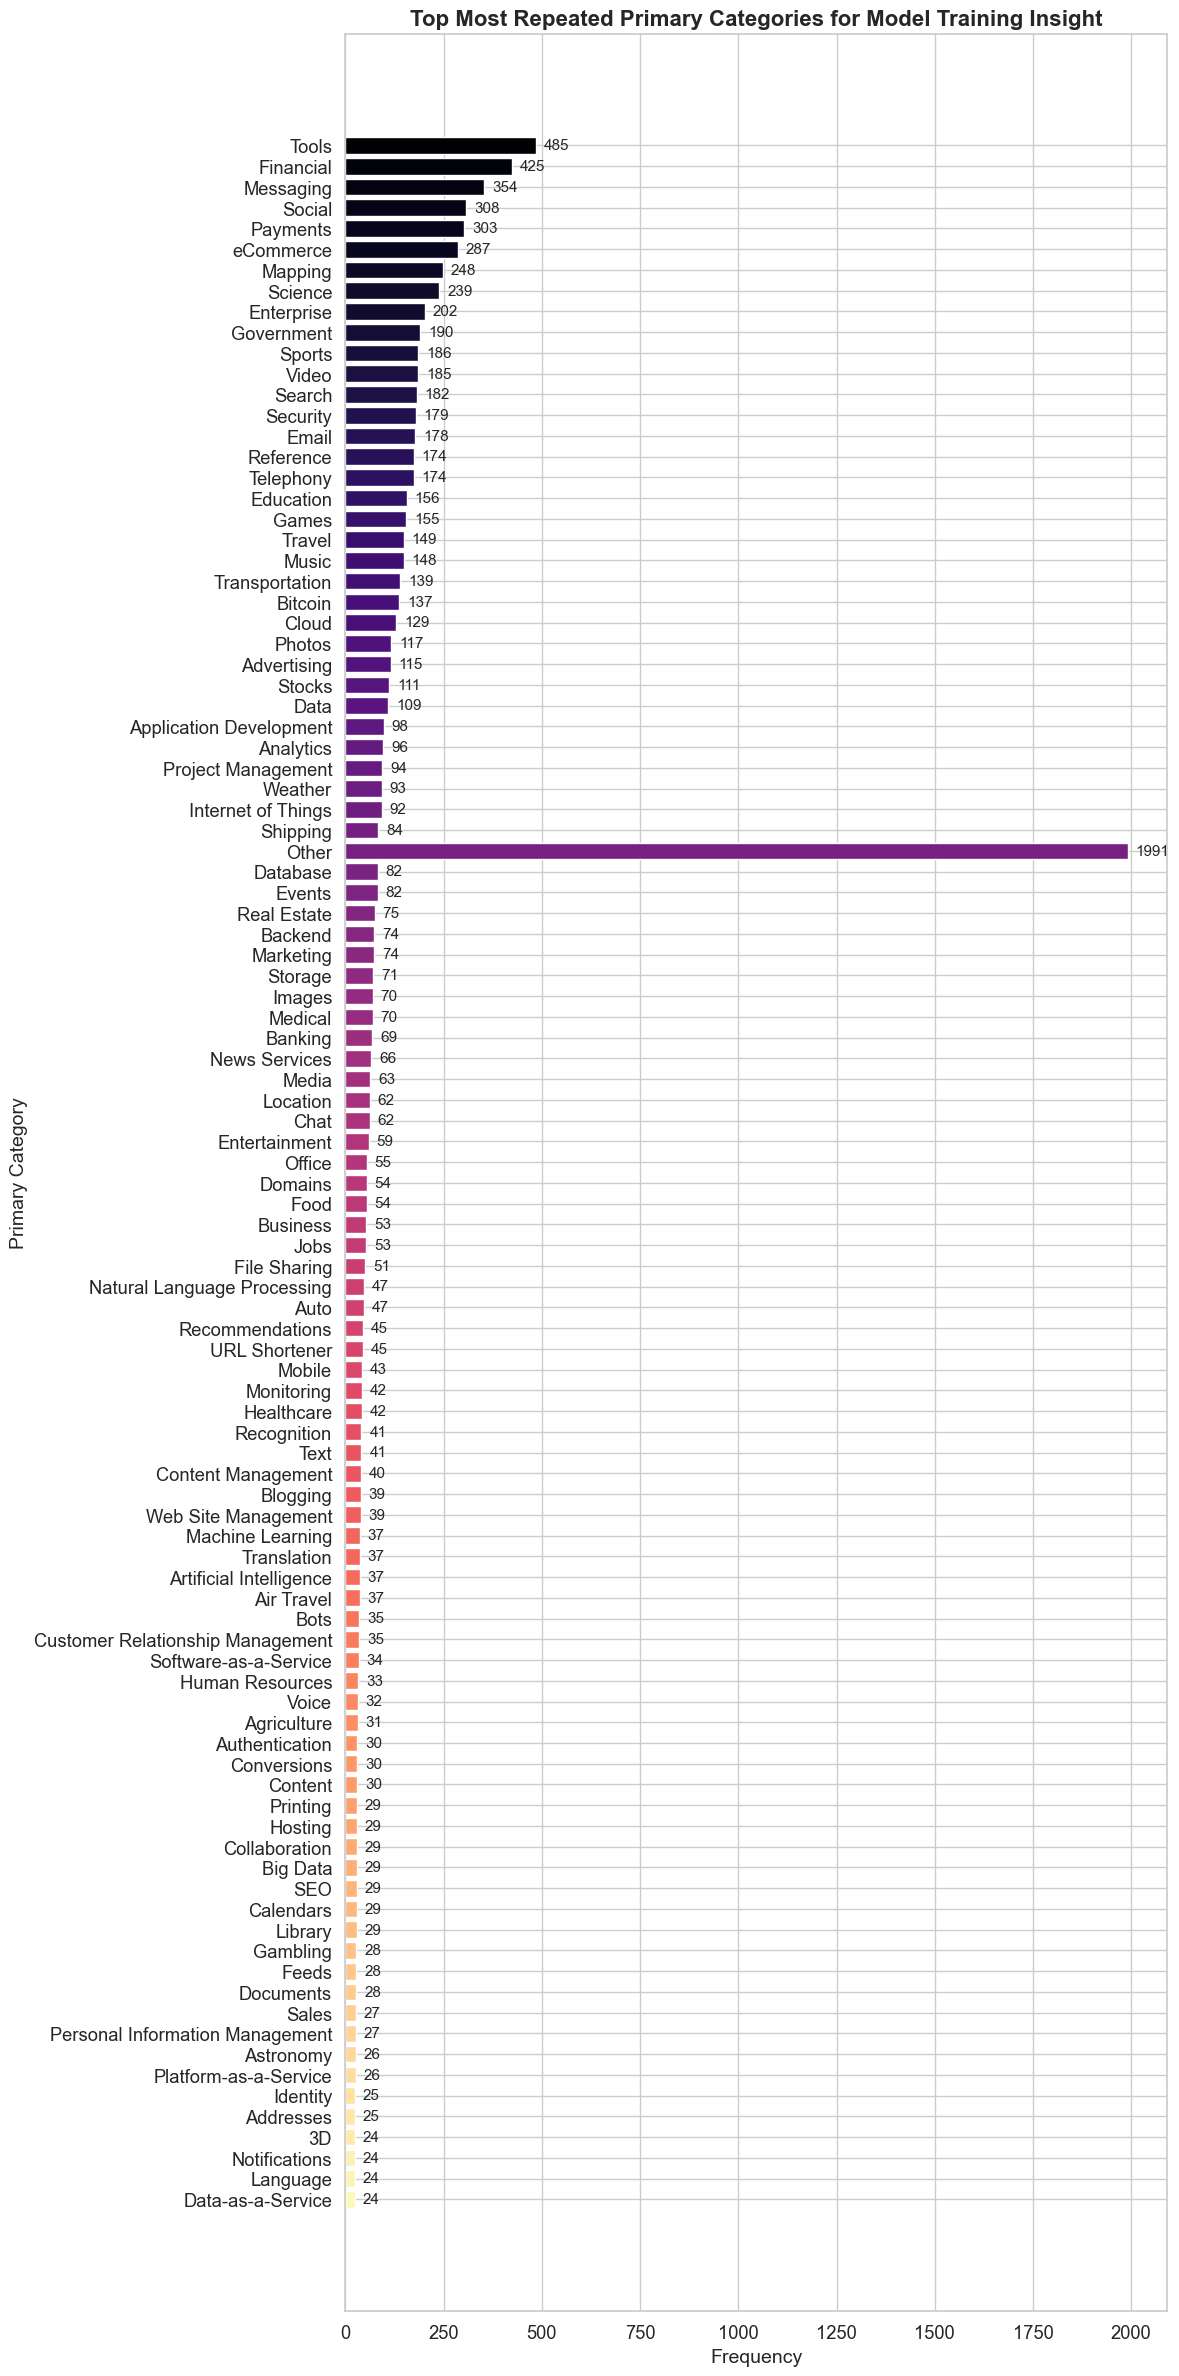

In [34]:
category_counts = new_df['PrimaryCategory'].value_counts()
top_categories = category_counts.head(top_n)

other_count = category_counts.iloc[top_n:].sum()
if other_count > 0:
    top_categories['Other'] = other_count

plt.figure(figsize=(12, 24))
sns.set_style('whitegrid')
colors = sns.color_palette("magma", len(top_categories))

bars = plt.barh(top_categories.index[::-1], top_categories.values[::-1], color=colors[::-1])

plt.title('Top Most Repeated Primary Categories for Model Training Insight', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Primary Category', fontsize=14)

for bar in bars:
    width = bar.get_width()
    plt.text(width + max(top_categories.values) * 0.01, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=11)

plt.tight_layout()
plt.show()